In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', '..', '..', '..', 'models')))

# Obliczanie odległości dla wybranych punktów

In [2]:
import numpy as np

LANDMARK_INDEXES = np.load(os.path.join('..', '..', '..', '..', 'data', 'landmarks', 'combined_selected_points_emotions.npy'))
REFERENCE_POINT_IDX = 0

In [3]:
from utils import load_data, convert_landmarks_to_distances

all_data, all_labels = load_data('real_life_deception_detection')
all_data = convert_landmarks_to_distances(all_data, LANDMARK_INDEXES, REFERENCE_POINT_IDX, normalize=True)

In [4]:
import torch
from torch.nn.utils.rnn import pad_sequence

tensor_data = [torch.tensor(d, dtype=torch.float32) for d in all_data]
padded_data = pad_sequence(tensor_data, batch_first=True)

## Average normalized distances per label

In [5]:
average_distances_per_frame = torch.mean(padded_data, dim=2)

In [6]:
avg_dist_lie = torch.mean(average_distances_per_frame[all_labels == 1], dim=0)
avg_dist_truth = torch.mean(average_distances_per_frame[all_labels == 0], dim=0)

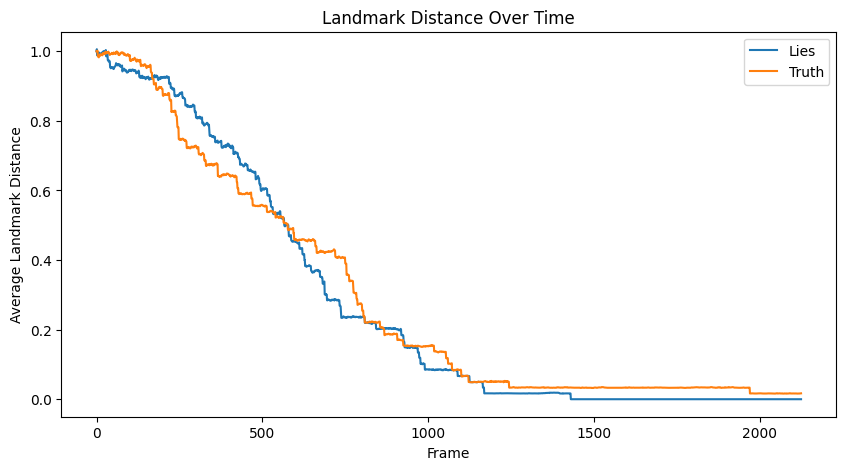

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(avg_dist_lie, label="Lies")
plt.plot(avg_dist_truth, label="Truth")

plt.xlabel('Frame')
plt.ylabel('Average Landmark Distance')
plt.title('Landmark Distance Over Time')
plt.legend()
plt.show()

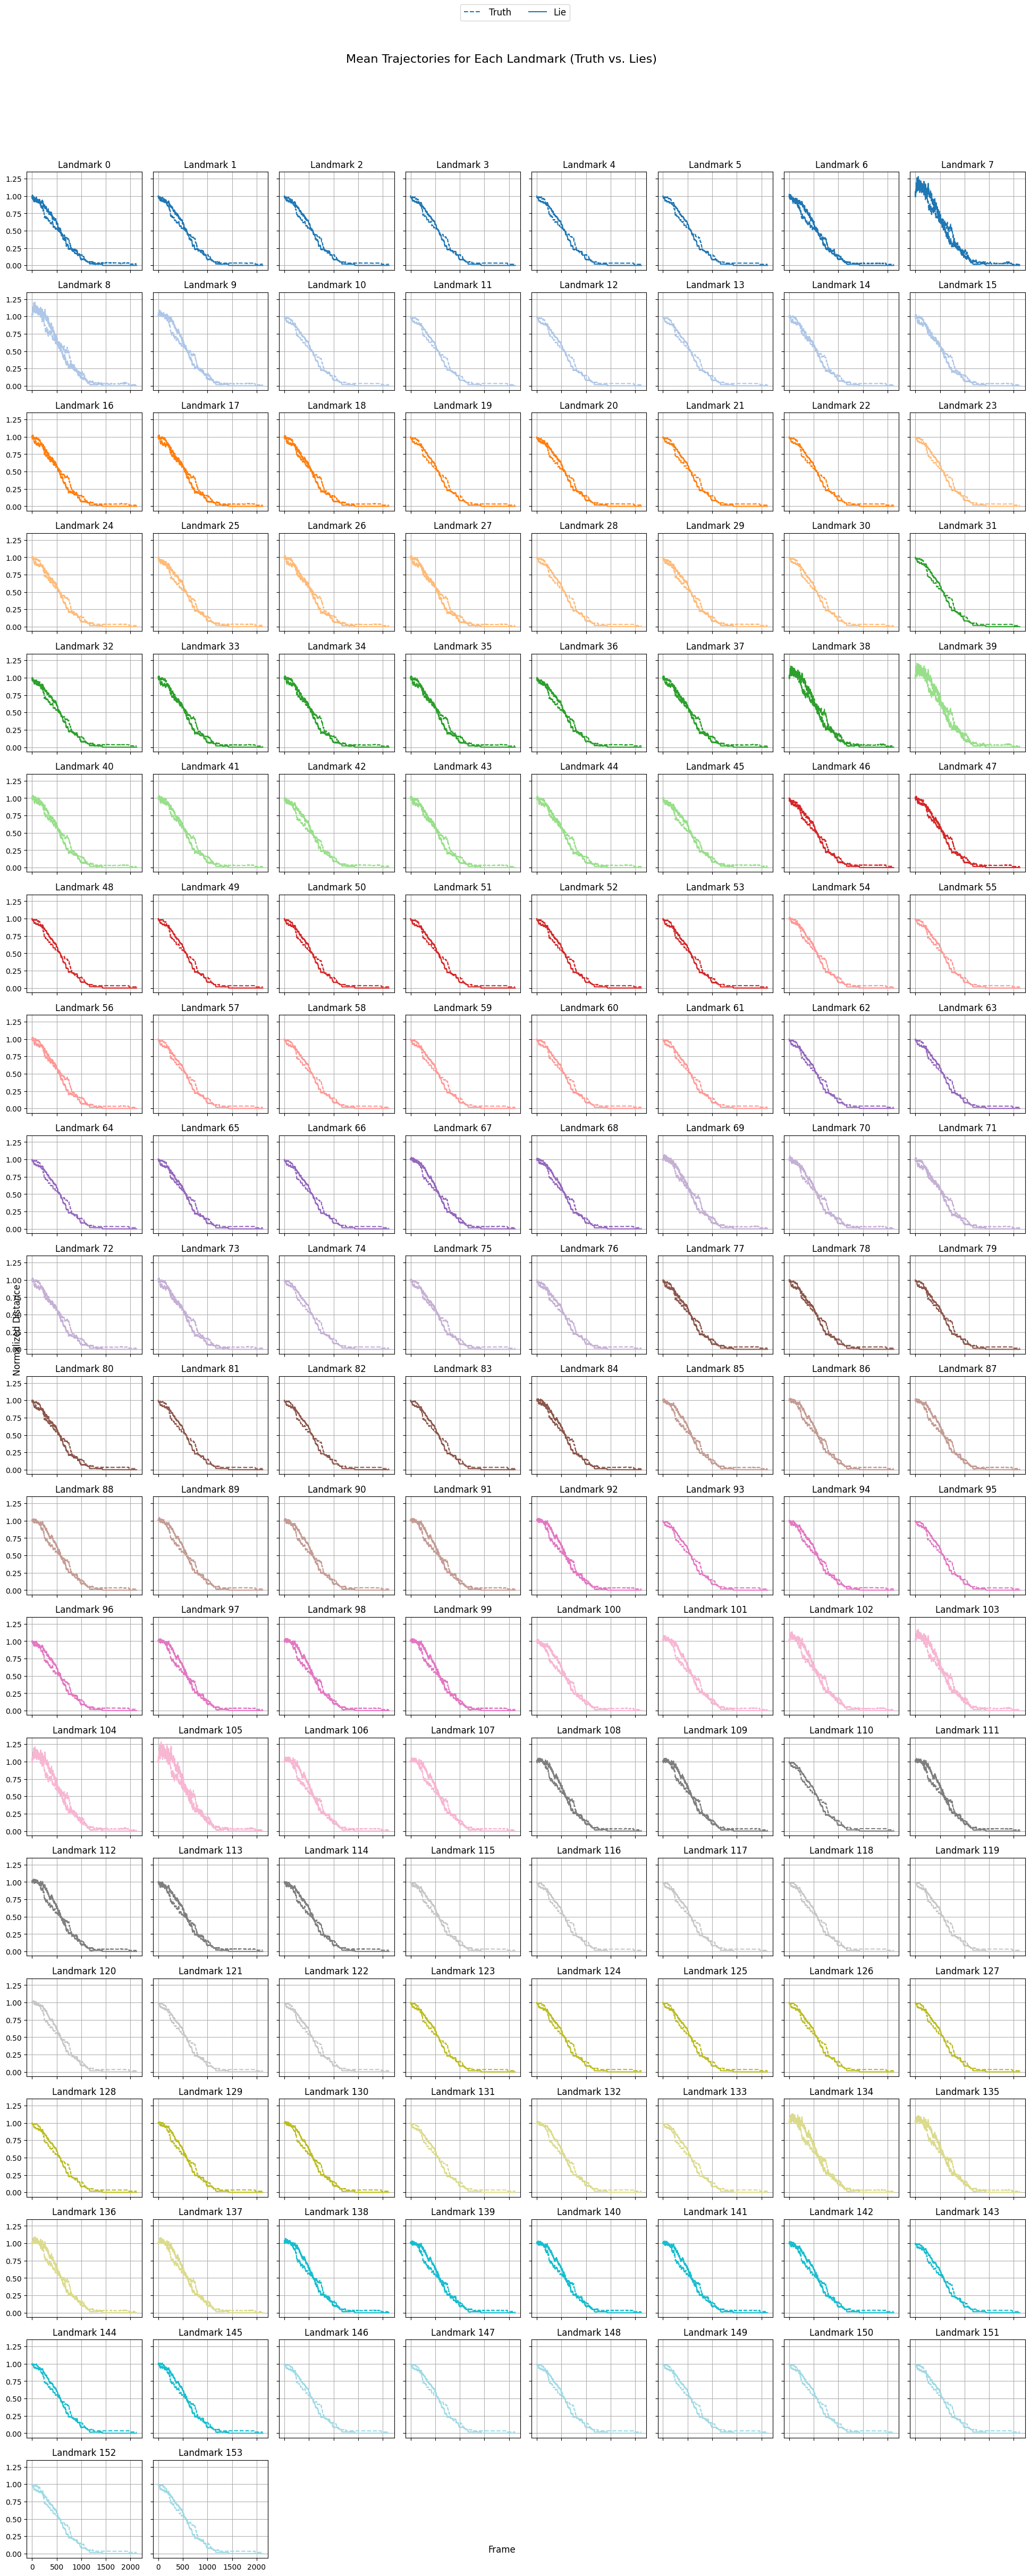

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Split data by label
smile = padded_data[all_labels == 0]       # Truth
deliberate = padded_data[all_labels == 1]  # Lie
# Compute mean across samples → shape: [609, 154]
smile_mean = smile.mean(axis=0)
deliberate_mean = deliberate.mean(axis=0)

# Plot all landmarks in a grid
n_landmarks = 154
n_cols = 8
n_rows = int(np.ceil(n_landmarks / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 2.5 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

cmap = plt.get_cmap('tab20', n_landmarks)  # diverse colormap

for i in range(n_landmarks):
    ax = axes[i]
    color = cmap(i)
    ax.plot(smile_mean[:, i], label='Truth', linestyle='--', color=color)
    ax.plot(deliberate_mean[:, i], label='Lie', linestyle='-', color=color)
    ax.set_title(f'Landmark {i}')
    ax.grid(True)

# Hide unused subplots if any
for j in range(n_landmarks, len(axes)):
    axes[j].axis('off')

# Add legend only once
fig.legend(['Truth', 'Lie'], loc='upper center', ncol=2, fontsize='large')
fig.suptitle('Mean Trajectories for Each Landmark (Truth vs. Lies)', fontsize=16)
fig.text(0.5, 0.04, 'Frame', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Normalized Distance', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.show()


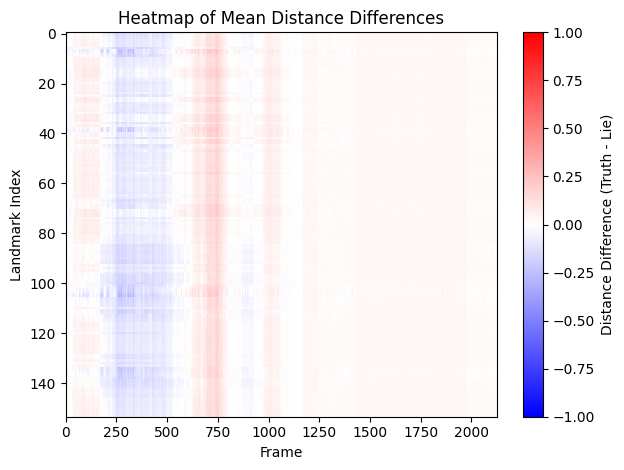

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


diff = smile_mean - deliberate_mean  # shape: [609, 158]

# Normalize the data between -1 and 1
norm = Normalize(vmin=-1, vmax=1)

# Create the heatmap with the normalized color scale
plt.imshow(diff.T, aspect='auto', cmap='bwr', interpolation='nearest', norm=norm)
plt.colorbar(label='Distance Difference (Truth - Lie)')
plt.xlabel('Frame')
plt.ylabel('Landmark Index')
plt.title('Heatmap of Mean Distance Differences')
plt.tight_layout()
plt.show()

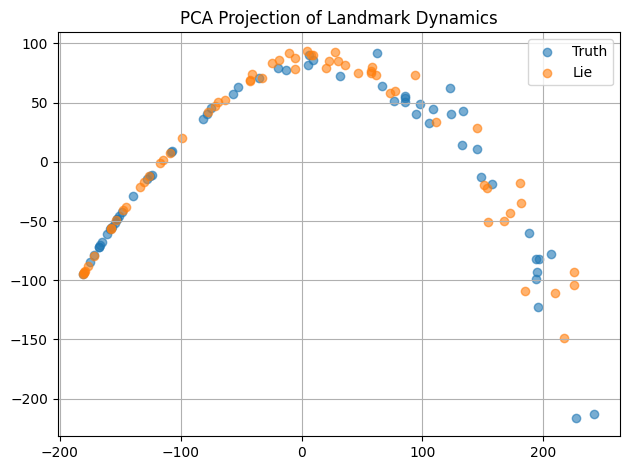

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Flatten each sample to 609×158 = 96122 features
X_flat = padded_data.reshape(padded_data.shape[0], -1)

# PCA (or t-SNE)
X_pca = PCA(n_components=2).fit_transform(X_flat)

# Plot
plt.scatter(X_pca[all_labels == 0, 0], X_pca[all_labels == 0, 1], label='Truth', alpha=0.6)
plt.scatter(X_pca[all_labels == 1, 0], X_pca[all_labels == 1, 1], label='Lie', alpha=0.6)
plt.title('PCA Projection of Landmark Dynamics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


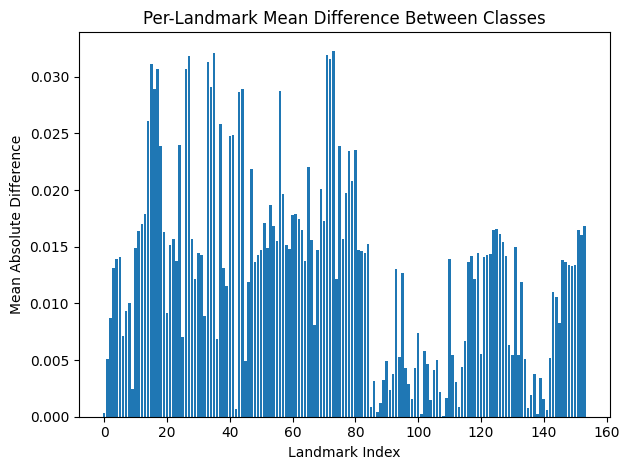

In [11]:
smile_mean_over_time = smile.mean(axis=1)  # shape: [N0, 158]
deliberate_mean_over_time = deliberate.mean(axis=1)  # shape: [N1, 158]

# Mean over samples again
mean_smile = smile_mean_over_time.mean(axis=0)
mean_deliberate = deliberate_mean_over_time.mean(axis=0)

diff_per_landmark = np.abs(mean_smile - mean_deliberate)

plt.bar(range(154), diff_per_landmark)
plt.xlabel('Landmark Index')
plt.ylabel('Mean Absolute Difference')
plt.title('Per-Landmark Mean Difference Between Classes')
plt.tight_layout()
plt.show()